In [165]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


df = pd.read_csv("daily_IBM.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2022-01-28,133.19,134.5300,131.790,134.50,5471497
1,2022-01-27,133.66,134.7500,132.080,132.52,5499566
2,2022-01-26,136.47,137.0700,133.130,134.26,8335992
3,2022-01-25,129.14,137.3361,128.300,136.10,19715698
4,2022-01-24,127.99,129.1500,124.193,128.82,13777648


In [166]:
train_dates = pd.to_datetime(df['timestamp'])
print(train_dates.head(15))

0    2022-01-28
1    2022-01-27
2    2022-01-26
3    2022-01-25
4    2022-01-24
5    2022-01-21
6    2022-01-20
7    2022-01-19
8    2022-01-18
9    2022-01-14
10   2022-01-13
11   2022-01-12
12   2022-01-11
13   2022-01-10
14   2022-01-07
Name: timestamp, dtype: datetime64[ns]


In [167]:
cols = list(df)[1:5]
print(cols)

['open', 'high', 'low', 'close']


In [168]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

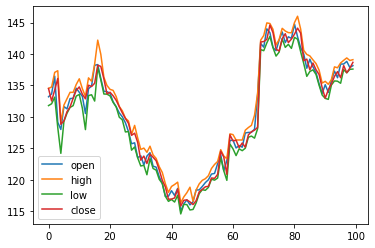

In [169]:
df_for_plot=df_for_training
df_for_plot.plot.line()

In [170]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [171]:
trainX = []
trainY = []

n_future = 1 
n_past = 3

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (97, 3, 4).
trainY shape == (97, 1).


In [172]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 3, 64)             17664     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 41ms/step - loss: 1.0656 - val_loss: 0.6045
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9421 - val_

In [182]:
import math
from sklearn.metrics import mean_squared_error
trainPredict = model.predict(trainX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))


Train Score: 0.25 RMSE


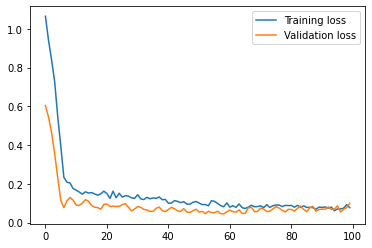

In [173]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [174]:
n_future = 1

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future, freq='A').tolist()

forecast = model.predict(trainX[-n_future:])

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [175]:
from numpy import array
x_input = array([[129.1500,124.193,127.99,128.82], [137.3361,128.300,129.14,136.10], [137.0700,133.130,136.47,134.26]])
x_input = x_input.reshape((1, 3, 4))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[223.00981]]


In [176]:
import pywebio
from pywebio.input import input, FLOAT
from pywebio.output import put_text, put_html, put_markdown, put_table

In [177]:
from numpy import array
x=[]
def stock_price():
    p1 = input("Input open value of Day 1：", type=FLOAT)
    p2 = input("Input high value of Day 1：", type=FLOAT)
    p3 = input("Input low value of Day 1：", type=FLOAT)
    p4 = input("Input close value of Day 1: ", type=FLOAT)
    p5 = input("Input open value of Day 2: ", type=FLOAT)
    p6 = input("Input high value of Day 2: ", type=FLOAT)
    p7 = input("Input low value of Day 2: ", type=FLOAT)
    p8 = input("Input close value of Day 2: ", type=FLOAT)
    p9 = input("Input open value of Day 3: ", type=FLOAT)
    p10 = input("Input high value of Day 3: ", type=FLOAT)
    p11 = input("Input low value of Day 3: ", type=FLOAT)
    p12 = input("Input close value of Day 3: ", type=FLOAT)
    x = array([[p1,p2,p3,p4],[p5,p6,p7,p8],[p9,p10,p11,p12]])
    x = x.reshape((1, 3, 4))
    final = model.predict(x, verbose=0)
    put_markdown('# **Results**')
    put_text('Predicted results: %.1f' % (final))
    put_html('<br><br>')
    put_markdown('Final results %1f' % (final))
    put_html('<hr>')

if __name__ == '__main__':
    pywebio.start_server(stock_price)
    
#a runtime error may occur while running this cell as the cell will be continously running.
#It does not affect the link generation or results.Just click on the link generated and input 10 previous days price and view the present day price pric

Running on all addresses.
Use http://192.168.26.224:65135/ to access the application


RuntimeError: This event loop is already running

# 